In [1]:
%env BOOST_HOME=/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/Boost/1.78.0-CrayGNU-21.09-python3
%env CUDA_ARCH=sm_60

env: BOOST_HOME=/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/Boost/1.78.0-CrayGNU-21.09-python3
env: CUDA_ARCH=sm_60


In [2]:

import numpy as np
import matplotlib.pyplot as plt

import gt4py
from gt4py import gtscript
import gt4py.storage as gt_storage

print(gt4py.config.BOOST_ROOT)

/apps/daint/UES/jenkins/7.0.UP03/21.09/daint-gpu/software/Boost/1.78.0-CrayGNU-21.09-python3


In [16]:
# backend = "gtc:cuda"
# backend = "gtc:dace"
# backend = "gtc:gt:cpu_ifirst"
backend = "gtc:numpy"
dtype = np.float64

In [17]:
@gtscript.function
def lap(in_field):
    out_field = (
        -4.0 * in_field
        + in_field[1, 0, 0]
        + in_field[-1, 0, 0]
        + in_field[0, 1, 0]
        + in_field[0, -1, 0]
    )
    return out_field


@gt4py.gtscript.stencil(backend=backend)
def laplap(in_field: gtscript.Field[dtype], out_field: gtscript.Field[dtype]):
    with computation(PARALLEL), interval(...):
        tmp = lap(in_field)
        out_field = lap(tmp)


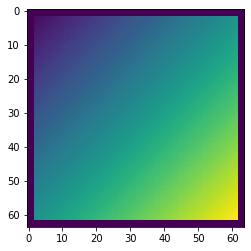

In [18]:
Nx = 64
Ny = 64
Nz = 20

shape = (Nx, Ny, Nz)
origin = (2, 2, 0)

in_storage = gt_storage.from_array(
    np.fromfunction(lambda x, y, _: x**5 + y**5, shape, dtype=dtype),
    default_origin=origin,
    backend=backend,
)
out_storage = gt_storage.from_array(
    np.zeros(shape, dtype=dtype), default_origin=origin, backend=backend
)

laplap(in_storage, out_storage)

out_storage.synchronize()

plt.imshow(np.asarray(out_storage)[:, :, 0])